In [99]:
import numpy as np
import matplotlib.pyplot as plt

# Von Bertalanffy growth model parameters
w_inf = 6       # Maximum possible biomass in kg
a = 1.113       # Growth constant (scales growth)
b = 1.097       # Shape parameter
adjustment_growth = 1.43        # Growth rate constant

# Initial conditions and costs
initial_biomass = 0.2            # Initial weight of fish in kg
initial_fish = 200000            # Initial number of fish in knot
harvesting_cost_per_kg = 4       # Cost of harvest per kg in NOK
feed_cost_per_kg_year = 5        # Cost of feed per kg per year in NOK
lice_treatment_cost = 1000000    # Cost of lice treatment
FCR_CCS = 1.25
FCR = 1.25
reduced_growth_treatment = 0.01  # How lice treatments will impact growth rate


# Host-parasite parameters     
mu = 0.025                       # Intrinsic mortality of salmon (OpenKnot)
alpha = 0.1                      # Mortality from lice per salmon
mu_smoltification_inc = 0.2
mu_smoltification_inc_css = 0.2
weight_mort_inc = 0.001
adjustment_mort = 0.001
lambda_growth = 7.0143           # Lice growth rate
lice_threshold = 0.5             # Lice per fish threshold for removal
beta1 = 0.0829                   # Beta distribution parameter for removal success
beta2 = 0.0281                   # Beta distribution parameter for removal success

# Mean-reversion parameters for spot price
mean_reversion_speed = 0.001
long_term_mean = 50
price_volatility = 0.2
initial_price = 50

# Simulation parameters
time_horizon = 3                 # in years
dt = 0.01                        # Time step
T = int(time_horizon / dt)       # Number of time steps
num_simulations = 10000          # Number of Monte Carlo paths
time = np.linspace(0, time_horizon, T)
r = 0.0303                       # Discount rate

# von Bertalanffy growth function for biomass B(t)
def biomass(t, w_inf, a, b, c, lice_per_fish_value):
    if lice_per_fish_value > 0:
        return w_inf * (a - b * np.exp(-c * t)) ** 3 + initial_biomass
    else:
        return w_inf * (a - b * np.exp(-c * t)) ** 3 + initial_biomass

# Simulate mean-reverting spot price (Ornstein-Uhlenbeck process)
def mean_reverting_price(P0, dt, T, mean_reversion_speed, long_term_mean, price_volatility):
    prices = np.zeros(T)
    prices[0] = P0
    for t in range(1, T):
        dP = mean_reversion_speed * (long_term_mean - prices[t-1]) * dt \
             + price_volatility * np.sqrt(dt) * np.random.randn()
        prices[t] = prices[t-1] + dP
    return prices

# Function to calculate dynamic mortality rate based on weight and lice count
def calculate_mortality_rate_dynamic(B_t, N_t, lice_per_fish_value, t, dt, adjustment_mort):
    if t * dt <= 3/12:  # First three months
        if lice_per_fish_value > 0:
            mortality_rate_dynamic = mu_smoltification_inc
        else:
            mortality_rate_dynamic = mu_smoltification_inc_css
    elif t*dt <= 1:
        if lice_per_fish_value > 0:
            mortality_rate_dynamic = mu + alpha * lice_per_fish_value
        else:
            mortality_rate_dynamic = mu
    else: 
        if lice_per_fish_value > 0:
            mortality_rate_dynamic = mu + (weight_mort_inc * B_t ** 2) + alpha * lice_per_fish_value
        else:
            mortality_rate_dynamic = mu + (adjustment_mort * B_t ** 2)
    return mortality_rate_dynamic

# Function to simulate fish population with cumulative mortality and calculate average dead weight
def simulate_paths(num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, initial_lice_per_fish, adjusted_FCR, adjusted_mort, adjustment_growth, lice_treatment_cost, adjustment_lambda_growth):
    # Initialize arrays to store simulation results
    all_values = np.zeros((num_simulations, T))
    harvesting_costs = np.zeros((num_simulations, T))
    feed_costs = np.zeros((num_simulations, T))
    treatment_costs = np.zeros((num_simulations, T))
    lice_per_fish = np.zeros((num_simulations, T))
    mortality_rate = np.zeros((num_simulations, T))
    total_mortality = np.zeros((num_simulations, T))
    average_dead_weight = np.zeros(num_simulations)  # To store average dead weight for each simulation
    B_t_array = np.zeros((num_simulations, T))  # Biomass at each time step
    D_t_array = np.zeros((num_simulations, T))  # Deaths at each time step

    for i in range(num_simulations):
        c_simulation = adjustment_growth
        N_t = initial_fish
        P_t = initial_lice_per_fish * N_t  # Initial lice population
        prices = mean_reverting_price(initial_price, dt, T, mean_reversion_speed, long_term_mean, price_volatility)
        cumulative_feed_cost = 0
        cumulative_treatment_cost = 0
        cumulative_death = 0

        for t in range(T):
            lice_per_fish_value = P_t / N_t
            lice_per_fish[i, t] = lice_per_fish_value
            B_t = biomass(t * dt, w_inf, a, b, c_simulation, lice_per_fish_value)
            B_t_array[i, t] = B_t  # Store B_t

            # Calculate dynamic mortality rate
            mortality_rate_dynamic = calculate_mortality_rate_dynamic(B_t, N_t, lice_per_fish_value, t, dt, adjusted_mort)
            mortality_rate[i, t] = mortality_rate_dynamic

            feed_cost_t = B_t * N_t * feed_cost_per_kg_year * dt * adjusted_FCR

            # Update number of fish based on cumulative mortality
            D_t = N_t * mortality_rate_dynamic * dt
            D_t_array[i, t] = D_t  # Store D_t
            cumulative_death += D_t
            N_t -= D_t
            N_t = max(N_t, 0)  # Ensure N_t doesn't go below zero

            # Update lice population
            if N_t > 0:
                P_t += (adjustment_lambda_growth * (N_t / initial_fish) - (mu + alpha * lice_per_fish_value)) * P_t * dt
            else:
                P_t = 0  # No fish left, so lice population is zero

            # Lice removal if the threshold is exceeded
            if lice_per_fish_value >= lice_threshold and N_t > 0:
                removal_success = 0.1 + 0.8 * np.random.beta(beta1, beta2)
                P_t *= (1 - removal_success)
                # Small mortality from treatment
                mortality_from_treatment = N_t * (1 - np.random.uniform(0.995, 1.0))
                N_t -= mortality_from_treatment
                N_t = max(N_t, 0)
                cumulative_treatment_cost += lice_treatment_cost
                c_simulation *= (1 - reduced_growth_treatment)

                # Add treatment deaths to D_t_array
                D_t_array[i, t] += mortality_from_treatment
                # Update cumulative_death with treatment deaths
                cumulative_death += mortality_from_treatment

            # Calculate feed cost and cumulative feed cost
            cumulative_feed_cost += feed_cost_t
            feed_costs[i, t] = cumulative_feed_cost

            # Calculate cumulative treatment cost
            treatment_costs[i, t] = cumulative_treatment_cost
            total_mortality[i, t] = cumulative_death

            # Value at time t (Biomass * Number of Fish * Spot Price) minus costs
            all_values[i, t] = B_t * N_t * prices[t] - feed_costs[i, t] - treatment_costs[i, t]
            harvesting_costs[i, t] = B_t * N_t * harvesting_cost_per_kg

        # Calculate average dead weight for this simulation
        total_D_t = np.sum(D_t_array)
        if total_D_t > 0:
            average_dead_weight[i] = np.sum(D_t_array * B_t_array) / total_D_t
        else:
            average_dead_weight[i] = 0  # No deaths occurred

    return (all_values, harvesting_costs, feed_costs, lice_per_fish, treatment_costs,
            mortality_rate, total_mortality, B_t_array, D_t_array)


# Run Monte Carlo simulation without lice
results_no_lice = simulate_paths(num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0, FCR_CCS, adjustment_mort, adjustment_growth, lice_treatment_cost, lambda_growth)
(simulated_values_no_lice, harvesting_costs_no_lice, feed_costs_no_lice, lice_per_fish_no_lice,
 treatment_costs_no_lice, mortality_rate_no_lice, cumulative_death_no_lice, B_t_no_Lice, D_t_no_Lice) = results_no_lice

# Run Monte Carlo simulation with initial lice infestation
results_lice = simulate_paths(num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.001, FCR, weight_mort_inc, adjustment_growth, lice_treatment_cost, lambda_growth)
(simulated_values, harvesting_costs, feed_costs, lice_per_fish, treatment_costs,
 mortality_rate, cumulative_death, B_t, D_t) = results_lice

# # Calculate average dead weight across all simulations
# mean_average_dead_weight = np.mean(average_dead_weight)
# mean_average_dead_weight_no_lice = np.mean(average_dead_weight_no_lice)

# print(f"Average weight at death with lice: {mean_average_dead_weight:.2f} kg")
# print(f"Average weight at death without lice: {mean_average_dead_weight_no_lice:.2f} kg")

# # Plotting simulated values
# plt.figure(figsize=(10, 6))
# for i in range(5):  # Plot 5 random B(t) paths with lice infestations
#     plt.plot(time, B_t[i, :], label=f"With Lice Path {i+1}")
# for i in range(5):  # Plot 5 random paths without lice
#     plt.plot(time, B_t_no_Lice[i, :], label=f"No Lice Path {i+1}")
# plt.title("Fish Weight over Time")
# plt.xlabel("Time (years)")
# plt.ylabel("Weight")
# plt.grid(True)
# plt.legend()
# plt.show()


# # Plotting cumulative mortality
# plt.figure(figsize=(10, 6))
# for i in range(5):  # Plot 5 random paths with lice infestations
#     plt.plot(time, cumulative_death[i, :], label=f"With Lice Path {i+1}")
# for i in range(5):  # Plot 5 random paths without lice
#     plt.plot(time, cumulative_death_no_lice[i, :], label=f"No Lice Path {i+1}")
# plt.title("Monte Carlo Simulations of Total Mortality")
# plt.xlabel("Time (years)")
# plt.ylabel("Cumulative Mortality")
# plt.grid(True)
# plt.legend()
# plt.show()

# # Plotting simulated values
# plt.figure(figsize=(10, 6))
# for i in range(5):  # Plot 5 random paths with lice infestations
#     plt.plot(time, simulated_values[i, :], label=f"With Lice Path {i+1}")
# for i in range(5):  # Plot 5 random paths without lice
#     plt.plot(time, simulated_values_no_lice[i, :], label=f"No Lice Path {i+1}")
# plt.title("Monte Carlo Simulations of Value")
# plt.xlabel("Time (years)")
# plt.ylabel("Value (NOK)")
# plt.grid(True)
# plt.legend()
# plt.show()

# # Plotting treatment and feed costs
# plt.figure(figsize=(10, 6))
# for i in range(5):  # Plot 5 random paths of treatment costs
#     plt.plot(time, treatment_costs[i, :], label=f"Treatment Cost Path {i+1}")
# for i in range(5):  # Plot 5 random paths of feed costs
#     plt.plot(time, feed_costs[i, :], label=f"Feed Cost Path {i+1}")
# plt.title("Monte Carlo Simulations of Treatment and Feed Costs")
# plt.xlabel("Time (years)")
# plt.ylabel("Cost (NOK)")
# plt.grid(True)
# plt.legend()
# plt.show()

# # Plotting treatment and feed costs
# plt.figure(figsize=(10, 6))
# for i in range(5):  # Plot 5 random paths of treatment costs
#     plt.plot(time, treatment_costs_no_lice[i, :], label=f"Treatment Cost Path {i+1}")
# for i in range(5):  # Plot 5 random paths of feed costs
#     plt.plot(time, feed_costs_no_lice[i, :], label=f"Feed Cost Path {i+1}")
# plt.title("Monte Carlo Simulations of Treatment and Feed Costs")
# plt.xlabel("Time (years)")
# plt.ylabel("Cost (NOK)")
# plt.grid(True)
# plt.legend()
# plt.show()

# # Plotting lice per fish dynamics
# plt.figure(figsize=(10, 6))
# for i in range(5):  # Plot 5 random paths
#     plt.plot(time, lice_per_fish[i, :], label=f"Path {i+1}")
# plt.axhline(lice_threshold, color='r', linestyle='--', label="Lice Threshold")
# plt.title("Lice per Fish Over Time")
# plt.xlabel("Time (years)")
# plt.ylabel("Lice per Fish")
# plt.grid(True)
# plt.legend()
# plt.show()

# # Plotting mortality rate dynamics
# plt.figure(figsize=(10, 6))
# for i in range(5):  # Plot 5 random paths with lice
#     plt.plot(time, mortality_rate[i, :], label=f"With Lice Path {i+1}")
# for i in range(5):  # Plot 5 random paths without lice
#     plt.plot(time, mortality_rate_no_lice[i, :], label=f"No Lice Path {i+1}")
# plt.title("Mortality Rate Over Time")
# plt.xlabel("Time (years)")
# plt.ylabel("Mortality Rate")
# plt.grid(True)
# plt.legend()
# plt.show()

# # Optional: Plotting the distribution of average dead weight
# plt.figure(figsize=(10, 6))
# plt.hist(average_dead_weight, bins=30, alpha=0.7, label='With Lice')
# plt.hist(average_dead_weight_no_lice, bins=30, alpha=0.7, label='Without Lice')
# plt.title("Distribution of Average Dead Weight")
# plt.xlabel("Average Dead Weight (kg)")
# plt.ylabel("Frequency")
# plt.legend()
# plt.grid(True)
# plt.show()


KeyboardInterrupt: 

In [33]:
from sklearn.linear_model import LinearRegression
import numpy as np

def continuation_value(value_salmon, discounted_payoff, degree=3):
    """
    Calculates the continuation value using polynomial regression.
    
    Parameters:
    - stock_prices: Stock prices at the current time step for in-the-money paths.
    - discounted_payoff: Discounted payoff for in-the-money paths.
    - degree: Degree of the polynomial for the regression (default: 2).
    
    Returns:
    - Continuation values for each stock price.
    """
    # Fit a polynomial regression model
    coeffs = np.polyfit(value_salmon, discounted_payoff, deg=degree)
    return np.polyval(coeffs, value_salmon)

def lsmc(paths, K, r, T, n_steps, B_t, D_t, poly_degree=3):
    """
    Implements the Longstaff-Schwartz Least Squares Monte Carlo (LSM) algorithm to price American options.

    Parameters:
        paths (ndarray): Simulated asset price paths (number of paths, number of time steps).
        K (float): Cost of Harvest C(H)
        r (float): Risk-free interest rate (annual).
        T (float): Maximum growth time (time to maturity)
        n_steps (int): Number of discrete time steps.
        poly_degree (int): Degree of polynomial used in regression for continuation values (default: 2).

    Returns:
        tuple: Estimated value of knot and an array of optimal exercise times.
    """
    dt = T / n_steps
    discount = np.exp(-r * dt)
    
    immediate_exercise_value = np.maximum(paths - K, 0)
    discounted_cash_flow = immediate_exercise_value[:, -1]
    exercise_times = np.full(paths.shape[0], n_steps)
    average_dead_weight = np.zeros(paths.shape[0])  # Fixed-size array for average dead weights


    for t in range(n_steps - 1, 0, -1):
        in_the_money = (paths[:, t] > K[:, t])
        paths_itm = np.where(in_the_money)[0]
        discounted_cash_flow *= discount

        if len(paths_itm) > 0:
            X = paths[paths_itm, t]
            Y = discounted_cash_flow[paths_itm]

            continuation_vals = continuation_value(X, Y, degree=poly_degree)
            exercise = immediate_exercise_value[in_the_money, t] > continuation_vals
            discounted_cash_flow[in_the_money] = np.where(exercise, immediate_exercise_value[in_the_money, t], Y)
            exercise_times[in_the_money] = np.where(exercise, t, exercise_times[in_the_money])
    for i in range(num_simulations):
        total_D_t = np.sum(D_t[i][:exercise_times[i] + 1])
        average_dead_weight[i] = np.sum(D_t[i][:exercise_times[i] + 1] * B_t[i][:exercise_times[i] + 1]) / total_D_t

    knot_value = np.mean(discounted_cash_flow) * discount
    return knot_value, exercise_times, average_dead_weight

In [34]:
knot_value, exercise_times, average_dead_weight = lsmc(simulated_values, harvesting_costs, r, time_horizon, T, B_t, D_t)
knot_value_no_lice, exercise_times_no_lice, average_dead_weight_no_lice = lsmc(simulated_values_no_lice, harvesting_costs, r, time_horizon, T, B_t_no_Lice, D_t_no_Lice)
    
print('One round of salmon farming with lice infestations is worth:', round(knot_value, 2), 'NOK')
print('One round of salmon farming without lice infestations is worth:', round(knot_value_no_lice, 2), 'NOK')

#Important to remember that this is only the revenue gain, not the gains in profits from no lice_removal costs
# results = np.zeros(M)

mean_average_dead_weight = np.mean(average_dead_weight)
mean_average_dead_weight_no_lice = np.mean(average_dead_weight_no_lice)

print(f"Average weight at death with lice: {mean_average_dead_weight:.2f} kg")
print(f"Average weight at death without lice: {mean_average_dead_weight_no_lice:.2f} kg")

One round of salmon farming with lice infestations is worth: 39810364.89 NOK
One round of salmon farming without lice infestations is worth: 46633996.98 NOK
Average weight at death with lice: 2.74 kg
Average weight at death without lice: 3.08 kg


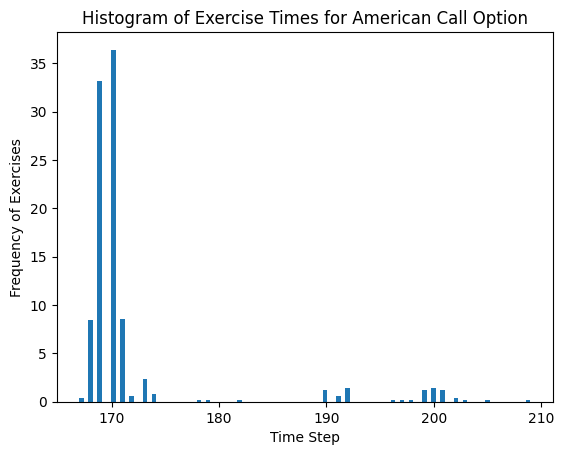

In [28]:
M = 5

all_exercise_times = np.array([])

# Perform M Monte Carlo simulations
for m in range(M):
    # Simulate paths
    paths, harvesting_costs, feed_costs, lice_per_fish, treatment_cost_lice, mortality_lice, _, B_t, D_t = simulate_paths(num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.001, FCR, mu_smoltification_inc, adjustment_growth)
    # Analyze the paths using the LSM method to get exercise times
    _, exercise_times, average_dead_weight = lsmc(paths, harvesting_costs, r, time_horizon, T, B_t, D_t)
    # Filter and collect all exercise times that are before the last step (i.e., early exercises)
    all_exercise_times = np.concatenate((all_exercise_times, exercise_times[exercise_times < T]))

# Plot the histogram
plt.hist(all_exercise_times, bins=T//3, weights=np.ones_like(all_exercise_times)/M)
plt.title('Histogram of Exercise Times for American Call Option')
plt.xlabel('Time Step')
plt.ylabel('Frequency of Exercises')
plt.show()


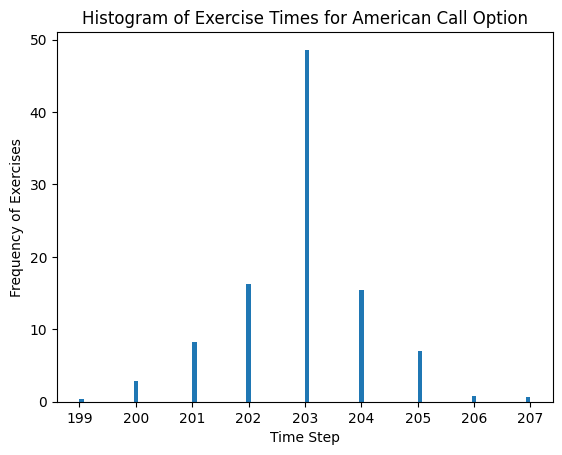

In [29]:
M = 5

all_exercise_times = np.array([])

# Perform M Monte Carlo simulations
for m in range(M):
    # Simulate paths
    paths, harvesting_costs, feed_costs, lice_per_fish, treatment_cost_lice, mortality_lice, _, B_t, D_t = simulate_paths(num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0, FCR_CCS, adjustment_mort, adjustment_growth)
    # Analyze the paths using the LSM method to get exercise times
    _, exercise_times, average_dead_weight = lsmc(paths, harvesting_costs, r, time_horizon, T, B_t, D_t)
    # Filter and collect all exercise times that are before the last step (i.e., early exercises)
    all_exercise_times = np.concatenate((all_exercise_times, exercise_times[exercise_times < T]))

# Plot the histogram
plt.hist(all_exercise_times, bins=T//3, weights=np.ones_like(all_exercise_times)/M)
plt.title('Histogram of Exercise Times for American Call Option')
plt.xlabel('Time Step')
plt.ylabel('Frequency of Exercises')
plt.show()

In [91]:
import pandas as pd

num_simulations = 100

# Adjusted scenarios: -5%, -10%, -15%, -20%
adjustments = [1, 0.95, 0.90, 0.85, 0.80]

# Results storage
results = []

# Run simulations for each scenario
for adjustment in adjustments:
    # Adjust variables
    adjusted_fcr = FCR_CCS * adjustment
    adjusted_mort = adjustment_mort * adjustment
    adjusted_growth = adjustment_growth * (2 - adjustment)

    # Run simulation with adjusted parameters
    paths, harvesting_costs, feed_costs, lice_per_fish, treatment_cost_lice, mortality_lice, _, B_t, D_t = simulate_paths(
        num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.00, adjusted_fcr, adjusted_mort, adjusted_growth, lice_treatment_cost, lambda_growth
    )

    # Analyze the paths using the LSM method
    value, exercise_times, average_dead_weight = lsmc(paths, harvesting_costs, r, time_horizon, T, B_t, D_t)
    

    # Calculate metrics
    average_dead_weight = np.mean(average_dead_weight)
    time_of_slaughter = np.mean(exercise_times * dt)
    slaughter_timestep = int(np.mean(exercise_times))
    fish_weight_at_slaughter = np.mean(B_t[:, slaughter_timestep])
    value_at_slaughter = value/1000000

    # Append results
    results.append({
        "Adjustment Level (%)": f"{round((1-adjustment)*100)}%",
        "FCR": round(adjusted_fcr, 4),
        "Weight Mortality Increment": round(adjusted_mort, 6),
        "Growth Rate (c)": round(adjusted_growth, 4),
        "Average Dead Weight (kg)": round(average_dead_weight, 2),
        "Fish Weight at Slaughter (kg)": round(fish_weight_at_slaughter, 2),
        "Time of Slaughter (years)": round(time_of_slaughter, 2),
        "Value at Slaughter (MNOK)": round(value_at_slaughter, 3)
    })

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results)
results_df


,Adjustment Level (%),FCR,Weight Mortality Increment,Growth Rate (c),Average Dead Weight (kg),Fish Weight at Slaughter (kg),Time of Slaughter (years),Value at Slaughter (MNOK)
0,0%,1.2500,0.00100,1.4300,3.11,7.20,2.03,46.434
1,5%,1.1875,0.00095,1.5015,3.12,7.27,1.98,47.631
2,10%,1.1250,0.00090,1.5730,3.14,7.35,1.94,48.960
3,15%,1.0625,0.00085,1.6445,3.18,7.44,1.91,50.106
4,20%,1.0000,0.00080,1.7160,3.17,7.51,1.86,51.233


In [ ]:
def run_scenarios():
    # Adjustments for the three parameters
    fcr_adjustments = [1, 0.95, 0.90, 0.85, 0.80]
    mort_adjustments = [1, 0.95, 0.90, 0.85, 0.80]
    growth_adjustments = [1, 0.95, 0.90, 0.85, 0.80]

    # Original baseline parameters
    baseline_fcr = FCR_CCS
    baseline_mort = adjustment_mort
    baseline_growth = adjustment_growth

    # Storage for results
    fcr_results = []
    mort_results = []
    growth_results = []

    # 1) Varying FCR only
    for adj in fcr_adjustments:
        adjusted_fcr = baseline_fcr * adj
        adjusted_mort = baseline_mort        # unchanged
        adjusted_growth = baseline_growth    # unchanged

        paths, harvesting_costs_, feed_costs_, lice_pf_, treatment_c_, mort_, _, B_t_, D_t_ = simulate_paths(
            num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.00, adjusted_fcr, adjusted_mort, adjusted_growth, lice_treatment_cost, lambda_growth
        )

        value, exercise_times_, avg_dead_wt_ = lsmc(paths, harvesting_costs_, r, time_horizon, T, B_t_, D_t_)
        avg_dead_weight_mean = np.mean(avg_dead_wt_)
        time_of_slaughter = np.mean(exercise_times_ * dt)
        slaughter_timestep = int(np.mean(exercise_times_))
        fish_weight_at_slaughter = np.mean(B_t_[:, slaughter_timestep])
        value_at_slaughter = value / 1_000_000

        fcr_results.append({
            # "FCR Adjustment (%)": f"{round((1 - adj)*100)}%",
            # "FCR": round(adjusted_fcr, 4),
            "Weight Mortality Increment": round(adjusted_mort, 6),
            # "Growth Rate (c)": round(adjusted_growth, 4),
            # "Average Dead Weight (kg)": round(avg_dead_weight_mean, 2),
            # "Fish Weight at Slaughter (kg)": round(fish_weight_at_slaughter, 2),
            # "Time of Slaughter (years)": round(time_of_slaughter, 2),
            "Value at Slaughter (MNOK)": round(value_at_slaughter, 3)
        })

    # 2) Varying Mortality Increment only
    for adj in mort_adjustments:
        adjusted_fcr = baseline_fcr
        adjusted_mort = baseline_mort * adj
        adjusted_growth = baseline_growth

        paths, harvesting_costs_, feed_costs_, lice_pf_, treatment_c_, mort_, _, B_t_, D_t_ = simulate_paths(
            num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.00, adjusted_fcr, adjusted_mort, adjusted_growth, lice_treatment_cost, lambda_growth
        )

        value, exercise_times_, avg_dead_wt_ = lsmc(paths, harvesting_costs_, r, time_horizon, T, B_t_, D_t_)
        avg_dead_weight_mean = np.mean(avg_dead_wt_)
        time_of_slaughter = np.mean(exercise_times_ * dt)
        slaughter_timestep = int(np.mean(exercise_times_))
        fish_weight_at_slaughter = np.mean(B_t_[:, slaughter_timestep])
        value_at_slaughter = value / 1_000_000

        mort_results.append({
            "Mortality Increment Adjustment (%)": f"{round((1 - adj)*100)}%",
            "FCR": round(adjusted_fcr, 4),
            "Weight Mortality Increment": round(adjusted_mort, 6),
            "Growth Rate (c)": round(adjusted_growth, 4),
            "Average Dead Weight (kg)": round(avg_dead_weight_mean, 2),
            "Fish Weight at Slaughter (kg)": round(fish_weight_at_slaughter, 2),
            "Time of Slaughter (years)": round(time_of_slaughter, 2),
            "Value at Slaughter (MNOK)": round(value_at_slaughter, 3)
        })

    # 3) Varying Growth only
    for adj in growth_adjustments:
        adjusted_fcr = baseline_fcr
        adjusted_mort = baseline_mort
        adjusted_growth = baseline_growth * (2 - adj)

        paths, harvesting_costs_, feed_costs_, lice_pf_, treatment_c_, mort_, _, B_t_, D_t_ = simulate_paths(
            num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.00, adjusted_fcr, adjusted_mort, adjusted_growth, lice_treatment_cost, lambda_growth
        )

        value, exercise_times_, avg_dead_wt_ = lsmc(paths, harvesting_costs_, r, time_horizon, T, B_t_, D_t_)
        avg_dead_weight_mean = np.mean(avg_dead_wt_)
        time_of_slaughter = np.mean(exercise_times_ * dt)
        slaughter_timestep = int(np.mean(exercise_times_))
        fish_weight_at_slaughter = np.mean(B_t_[:, slaughter_timestep])
        value_at_slaughter = value / 1_000_000

        growth_results.append({
            "Growth Adjustment (%)": f"{round((2 - adj)*100)}%",
            "FCR": round(adjusted_fcr, 4),
            "Weight Mortality Increment": round(adjusted_mort, 6),
            "Growth Rate (c)": round(adjusted_growth, 4),
            "Average Dead Weight (kg)": round(avg_dead_weight_mean, 2),
            "Fish Weight at Slaughter (kg)": round(fish_weight_at_slaughter, 2),
            "Time of Slaughter (years)": round(time_of_slaughter, 2),
            "Value at Slaughter (MNOK)": round(value_at_slaughter, 3)
        })

    # Convert results to DataFrames
    fcr_results_df = pd.DataFrame(fcr_results)
    mort_results_df = pd.DataFrame(mort_results)
    growth_results_df = pd.DataFrame(growth_results)

    # Print and return the three results tables
    print("FCR Variation Results:")
    display(fcr_results_df)

    print("\nMortality Increment Variation Results:")
    display(mort_results_df)

    print("\nGrowth Variation Results:")
    display(growth_results_df)

    return fcr_results_df, mort_results_df, growth_results_df


# After defining the function, you can call:
fcr_df, mort_df, growth_df = run_scenarios()

FCR Variation Results:


,FCR Adjustment (%),FCR,Weight Mortality Increment,Growth Rate (c),Average Dead Weight (kg),Fish Weight at Slaughter (kg),Time of Slaughter (years),Value at Slaughter (MNOK)
0,0%,1.2500,0.001,1.43,3.09,7.18,2.02,46.402
1,5%,1.1875,0.001,1.43,3.16,7.24,2.05,46.727
2,10%,1.1250,0.001,1.43,3.19,7.25,2.07,47.265
3,15%,1.0625,0.001,1.43,3.24,7.30,2.09,47.694
4,20%,1.0000,0.001,1.43,3.26,7.32,2.10,48.085



Mortality Increment Variation Results:


,Mortality Increment Adjustment (%),FCR,Weight Mortality Increment,Growth Rate (c),Average Dead Weight (kg),Fish Weight at Slaughter (kg),Time of Slaughter (years),Value at Slaughter (MNOK)
0,0%,1.25,0.00100,1.43,3.13,7.22,2.04,46.418
1,5%,1.25,0.00095,1.43,3.11,7.24,2.05,46.554
2,10%,1.25,0.00090,1.43,3.06,7.22,2.05,46.587
3,15%,1.25,0.00085,1.43,3.05,7.25,2.06,46.682
4,20%,1.25,0.00080,1.43,2.99,7.24,2.06,46.769



Growth Variation Results:


,Growth Adjustment (%),FCR,Weight Mortality Increment,Growth Rate (c),Average Dead Weight (kg),Fish Weight at Slaughter (kg),Time of Slaughter (years),Value at Slaughter (MNOK)
0,100%,1.25,0.001,1.4300,3.08,7.17,2.02,46.462
1,105%,1.25,0.001,1.5015,3.10,7.23,1.95,47.174
2,110%,1.25,0.001,1.5730,3.13,7.28,1.90,47.919
3,115%,1.25,0.001,1.6445,3.16,7.34,1.85,48.583
4,120%,1.25,0.001,1.7160,3.15,7.37,1.78,49.242


In [100]:
import pandas as pd


# Adjusted scenarios: -5%, -10%, -15%, -20%
adjustments = [1, 0.95, 0.90, 0.85, 0.80]

num_simulations = 10000

# Results storage
results = []

# Run simulations for each scenario
for adjustment in adjustments:
    # Adjust variables
    adjusted_fcr = FCR_CCS * adjustment
    adjusted_mort = adjustment_mort * adjustment
    adjusted_growth = adjustment_growth * (2 - adjustment)

    # Run simulation with adjusted parameters
    paths, harvesting_costs, feed_costs, lice_per_fish, treatment_cost_lice, mortality_lice, _, B_t, D_t = simulate_paths(
        num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.001, adjusted_fcr, adjusted_mort, adjusted_growth, lice_treatment_cost, lambda_growth
    )

    # Analyze the paths using the LSM method
    value, exercise_times, average_dead_weight = lsmc(paths, harvesting_costs, r, time_horizon, T, B_t, D_t)
    

    # Calculate metrics
    average_dead_weight = np.mean(average_dead_weight)
    time_of_slaughter = np.mean(exercise_times * dt)
    slaughter_timestep = int(np.mean(exercise_times))
    fish_weight_at_slaughter = np.mean(B_t[:, slaughter_timestep])
    value_at_slaughter = value

    # Append results
    results.append({
        "Adjustment Level (%)": f"{round((1-adjustment)*100)}%",
        "FCR": round(adjusted_fcr, 4),
        "Weight Mortality Increment": round(adjusted_mort, 6),
        "Growth Rate (c)": round(adjusted_growth, 4),
        "Average Dead Weight (kg)": round(average_dead_weight, 2),
        "Fish Weight at Slaughter (kg)": round(fish_weight_at_slaughter, 2),
        "Time of Slaughter (years)": round(time_of_slaughter, 2),
        "Value at Slaughter (NOK)": round(value_at_slaughter, 2)
    })

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results)
results_df


,Adjustment Level (%),FCR,Weight Mortality Increment,Growth Rate (c),Average Dead Weight (kg),Fish Weight at Slaughter (kg),Time of Slaughter (years),Value at Slaughter (NOK)
0,0%,1.2500,0.00100,1.4300,2.73,6.37,1.70,39960180.06
1,5%,1.1875,0.00095,1.5015,2.90,6.59,1.70,41507414.01
2,10%,1.1250,0.00090,1.5730,3.05,6.76,1.70,42936087.38
3,15%,1.0625,0.00085,1.6445,3.20,6.93,1.70,44244212.44
4,20%,1.0000,0.00080,1.7160,3.32,7.07,1.69,45468300.57


In [101]:
import pandas as pd

num_simulations = 10000

# Adjusted scenarios: -5%, -10%, -15%, -20%
adjustments = [1, 0.95, 0.90, 0.85, 0.80]

# Results storage
results = []

# Run simulations for each scenario
for adjustment in adjustments:
    # Adjust variables
    adjusted_fcr = FCR_CCS * adjustment
    adjusted_mort = adjustment_mort * adjustment
    adjusted_growth = adjustment_growth * (2 - adjustment)

    # Run simulation with adjusted parameters
    paths, harvesting_costs, feed_costs, lice_per_fish, treatment_cost_lice, mortality_lice, _, B_t, D_t = simulate_paths(
        num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.001, adjusted_fcr, adjusted_mort, adjusted_growth, lice_treatment_cost, lambda_growth
    )

    # Analyze the paths using the LSM method
    value, exercise_times, average_dead_weight = lsmc(paths, harvesting_costs, r, time_horizon, T, B_t, D_t)
    

    # Calculate metrics
    average_dead_weight = np.mean(average_dead_weight)
    time_of_slaughter = np.mean(exercise_times * dt)
    slaughter_timestep = int(np.mean(exercise_times))
    fish_weight_at_slaughter = np.mean(B_t[:, slaughter_timestep])
    value_at_slaughter = value

    # Append results
    results.append({
        "Adjustment Level (%)": f"{round((1-adjustment)*100)}%",
        "FCR": round(adjusted_fcr, 4),
        "Weight Mortality Increment": round(adjusted_mort, 6),
        "Growth Rate (c)": round(adjusted_growth, 4),
        "Average Dead Weight (kg)": round(average_dead_weight, 2),
        "Fish Weight at Slaughter (kg)": round(fish_weight_at_slaughter, 2),
        "Time of Slaughter (years)": round(time_of_slaughter, 2),
        "Value at Slaughter (NOK)": round(value_at_slaughter, 2)
    })

# Convert results to a DataFrame and display
results_df = pd.DataFrame(results)
results_df

,Adjustment Level (%),FCR,Weight Mortality Increment,Growth Rate (c),Average Dead Weight (kg),Fish Weight at Slaughter (kg),Time of Slaughter (years),Value at Slaughter (NOK)
0,0%,1.2500,0.00100,1.4300,2.73,6.37,1.70,39972600.90
1,5%,1.1875,0.00095,1.5015,2.90,6.59,1.70,41497994.02
2,10%,1.1250,0.00090,1.5730,3.05,6.76,1.70,42931849.49
3,15%,1.0625,0.00085,1.6445,3.19,6.93,1.69,44275125.90
4,20%,1.0000,0.00080,1.7160,3.32,7.07,1.69,45467968.25


1.3212960000000002 4200000.0
1.3220620000000003 4116326.5306122447
1.3211240000000002 4032653.06122449
1.3214700000000001 3948979.5918367347
1.3684940000000003 3865306.1224489794
1.4113060000000002 3781632.6530612246
1.416396 3697959.1836734693
1.415292 3614285.7142857146
1.42496 3530612.2448979593
1.422194 3446938.775510204
1.4260700000000002 3363265.306122449
1.6545399999999997 3279591.836734694
1.672996 3195918.3673469387
1.6758019999999996 3112244.897959184
1.6859679999999997 3028571.4285714286
1.6902199999999996 2944897.9591836734
1.6898819999999999 2861224.4897959186
1.6912079999999998 2777551.0204081633
1.6905400000000002 2693877.551020408
1.686616 2610204.0816326533
1.6937959999999999 2526530.612244898
1.6932919999999998 2442857.1428571427
1.6930180000000001 2359183.673469388
1.693214 2275510.2040816327
1.6942899999999999 2191836.7346938774
1.6982959999999998 2108163.2653061226
1.69528 2024489.7959183673
1.6951880000000001 1940816.326530612
1.696704 1857142.8571428573
1.6977419

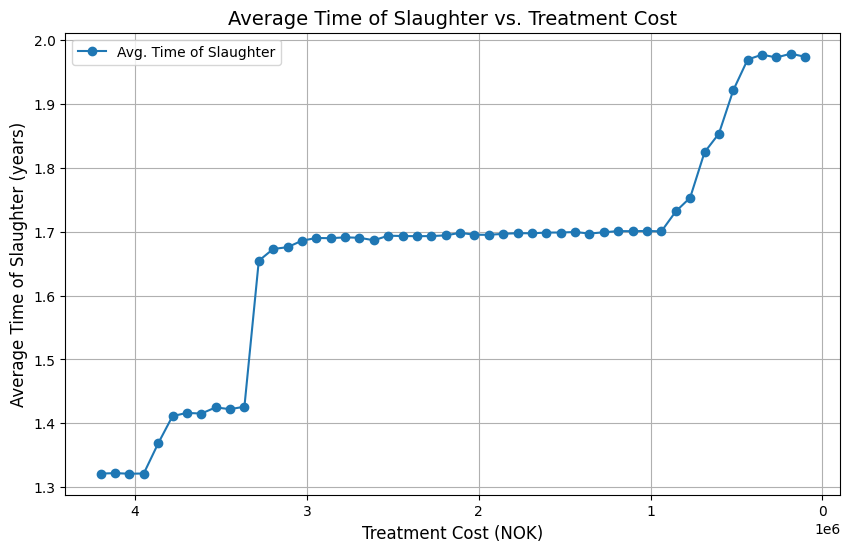

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the treatment costs (20 values between 1 million and 400,000)
treatment_costs = np.linspace(4200000, 100000, 20)

num_simulations = 10000

# Placeholder for average time of slaughter values
# Replace these with actual simulation results
average_times_of_slaughter = []
for cost in treatment_costs:
    # Adjust variables for the simulation
    adjusted_lice_treatment_cost = cost
    # Simulate with adjusted treatment cost (assuming your function and variables are defined)
    paths, harvesting_costs, feed_costs, lice_per_fish, treatment_cost_lice, mortality_lice, _, B_t, D_t = simulate_paths(
        num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.001, FCR_CCS, adjustment_mort, adjustment_growth, adjusted_lice_treatment_cost
    )
    # Analyze the paths using the LSM method
    value, exercise_times, average_dead_weight = lsmc(paths, harvesting_costs, r, time_horizon, T, B_t, D_t)

    # Calculate the average time of slaughter
    time_of_slaughter = np.mean(exercise_times * dt)
    average_times_of_slaughter.append(time_of_slaughter)
    print(time_of_slaughter, cost)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(treatment_costs, average_times_of_slaughter, marker='o', linestyle='-', label='Avg. Time of Slaughter')
plt.xlabel('Treatment Cost (NOK)', fontsize=12)
plt.ylabel('Average Time of Slaughter (years)', fontsize=12)
plt.title('Average Time of Slaughter vs. Treatment Cost', fontsize=14)
plt.grid(True)
plt.gca().invert_xaxis()  # Invert x-axis to show higher treatment cost on the left
plt.legend()
plt.show()


In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Define the treatment costs (20 values between 1 million and 400,000)
adjustment_lambda_growths = np.linspace(5, 10, 50)

num_simulations = 10000

# Placeholder for average time of slaughter values
# Replace these with actual simulation results
average_times_of_slaughter = []
for lambda_growth in adjustment_lambda_growths:
    # Adjust variables for the simulation
    adjustment_lambda_growth = lambda_growth
    # Simulate with adjusted treatment cost (assuming your function and variables are defined)
    paths, harvesting_costs, feed_costs, lice_per_fish, treatment_cost_lice, mortality_lice, _, B_t, D_t = simulate_paths(
        num_simulations, harvesting_cost_per_kg, feed_cost_per_kg_year, 0.001, FCR_CCS, adjustment_mort, adjustment_growth, lice_treatment_cost, adjustment_lambda_growth
    )
    # Analyze the paths using the LSM method
    value, exercise_times, average_dead_weight = lsmc(paths, harvesting_costs, r, time_horizon, T, B_t, D_t)

    # Calculate the average time of slaughter
    time_of_slaughter = np.mean(exercise_times * dt)
    average_times_of_slaughter.append(time_of_slaughter)
    print(time_of_slaughter, lambda_growth)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(adjustment_lambda_growths[::-1], average_times_of_slaughter[::-1], marker='o', linestyle='-', label='Avg. Time of Slaughter')
plt.xlabel('Lambda Growth (NOK)', fontsize=12)
plt.ylabel('Average Time of Slaughter (years)', fontsize=12)
plt.title('Average Time of Slaughter vs. Lambda Growth', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

1.8514970000000004 5.0
1.8165209999999998 5.1020408163265305
1.7834380000000005 5.204081632653061
1.75137 5.3061224489795915
1.717011 5.408163265306122
1.6833489999999998 5.510204081632653


KeyboardInterrupt: 

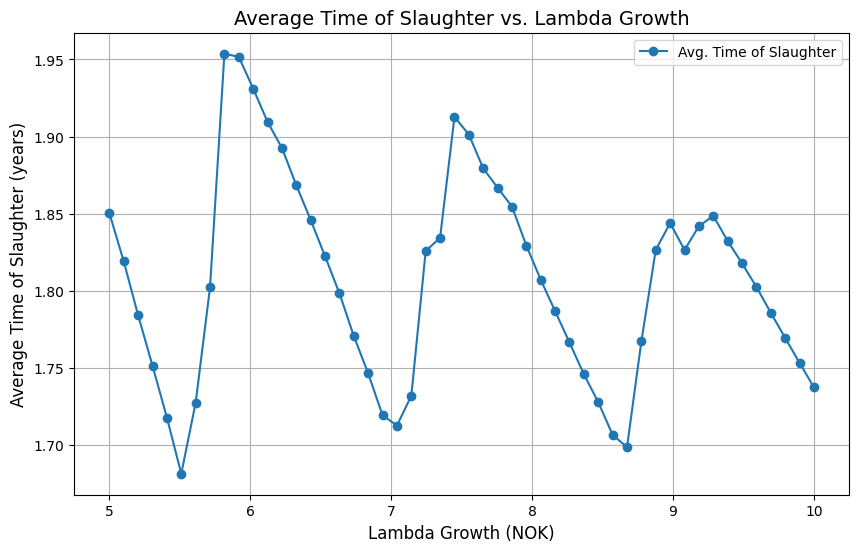